<a href="https://colab.research.google.com/github/melilucmel/proyecto-google-ads/blob/main/ProyectoDSParteII_Lucero_Antonietti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final – Parte II

En la **primera parte** del proyecto (entrega inicial) se realizó la **limpieza, preparación y exploración de datos**, junto con un análisis visual y descriptivo de las campañas de Google Ads.

En esta **segunda parte** se avanza hacia la aplicación de modelos de Machine Learning, con el propósito de evaluar la capacidad predictiva de distintas variables de rendimiento.

**El trabajo incluye la evaluación de dos targets distintos**, buscando comprobar su poder predictivo, aunque los resultados no fueron los esperados.

Se desarrollan los siguientes pasos:

- **Selección y creación de features**, incorporando métricas clave de marketing (Clicks, Impressions, Cost, Leads, Conversions, Device, etc.).

- **Entrenamiento de modelos**: Dummy (baseline), Regresión Lineal y Random Forest.

- **Evaluación de métricas** (R², RMSE, MAE) y visualizaciones comparativas de desempeño.


El **objetivo** principal es **determinar si los modelos de Machine Learning pueden aplicarse de manera práctica en marketing digital para predecir métricas de rendimiento** con precisión.

## 0) Hipótesis

**Hipótesis nula (H0):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) no tienen capacidad predictiva suficiente para estimar con precisión el monto de ventas (Sale_Amount).

**Hipótesis alternativa (H1):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) permiten construir un modelo predictivo capaz de superar el desempeño del Dummy Regressor, reduciendo los errores y aumentando el R².

## 1) Carga y exploración el dataset

In [23]:
import pandas as pd

# Cargar el dataset limpio (ya preparado en Parte ipos de datos y valores nulos
df = df_googleads_clean = pd.read_csv("https://raw.githubusercontent.com/melilucmel/proyecto-google-ads/refs/heads/main/DataSetII_GoogleAds_Clean.csv")

print("//Info general//\n")
print(df.info())

print("\n//Primeras filas//\n")
print(df.head())

print("\n//Valores nulos por columna//\n")
print(df.isnull().sum())

//Info general//

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ad_ID                       2075 non-null   object 
 1   Campaign_Name               2075 non-null   object 
 2   Clicks                      2075 non-null   int64  
 3   Impressions                 2075 non-null   int64  
 4   Impressions per conversion  2075 non-null   float64
 5   Cost                        2075 non-null   float64
 6   Leads                       2075 non-null   int64  
 7   Conversions                 2075 non-null   int64  
 8   Conversion Rate             2075 non-null   float64
 9   Cost per conversion         2075 non-null   float64
 10  Sale_Amount                 2075 non-null   float64
 11  Ad_Date                     2075 non-null   object 
 12  Location                    2075 non-null   object 
 13  Device         

## 2) Definición de target y features (X e y)

In [24]:
# Defino Target
TARGET = "Sale_Amount"

# Seleccionamos columnas relevantes (ajustaremos después con Feature Selection)
features_iniciales = [
    "Cost", "Clicks", "Impressions", "Leads", "Conversions", "Device"
]

X = df[features_iniciales]
y = df[TARGET]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 6)
Dimensiones de y: (2075,)


## 3) Feature Selection

En esta sección aplicamos dos enfoques simples y vistos en clase para priorizar variables:

3.a) **Correlación** con el target (`Sale_Amount`) para variables numéricas.

3.b) **Importancia de variables con RandomForest** (incluye categóricas mediante One-Hot).

### 3.a) Correlación con el target

//Correlación con Sale_Amount//
Sale_Amount                   1.000000
Clicks                        0.037701
Cost per conversion           0.015910
Impressions                   0.010249
Impressions per conversion    0.010052
Leads                         0.007158
Cost                          0.007085
Conversions                  -0.017356
Conversion Rate              -0.051156
Name: Sale_Amount, dtype: float64


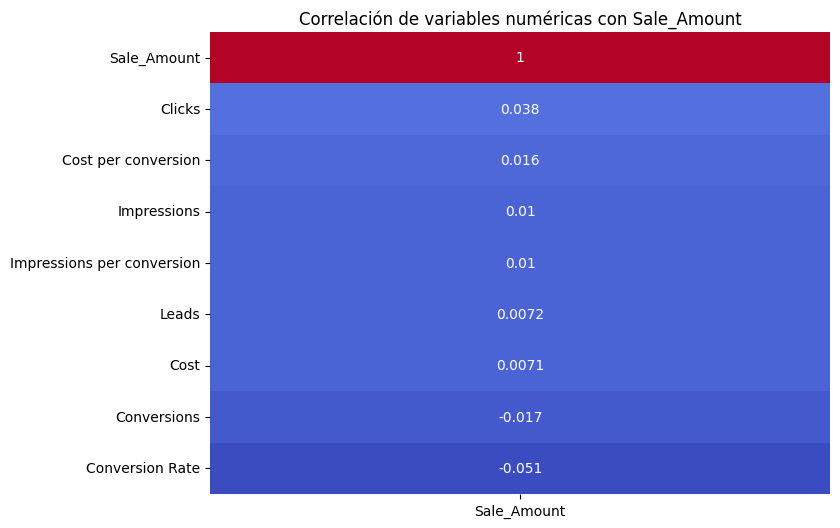

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo columnas numéricas
num_cols = df.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()

# Matriz de correlación
corr = df[num_cols].corr()

# Correlación de cada variable con el target Sale_Amount
corr_target = corr["Sale_Amount"].sort_values(ascending=False)

print("//Correlación con Sale_Amount//")
print(corr_target)

# Gráfico de calor (top variables)
plt.figure(figsize=(8,6))
sns.heatmap(corr_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlación de variables numéricas con Sale_Amount")
plt.show()

### 3.b) Importancia de variables con RandomForest

//Importancia de variables (RandomForest)//
Impressions       0.250502
Cost              0.248669
Clicks            0.204508
Leads             0.141109
Conversions       0.094713
Device_desktop    0.021599
Device_tablet     0.020777
Device_mobile     0.018123
dtype: float64


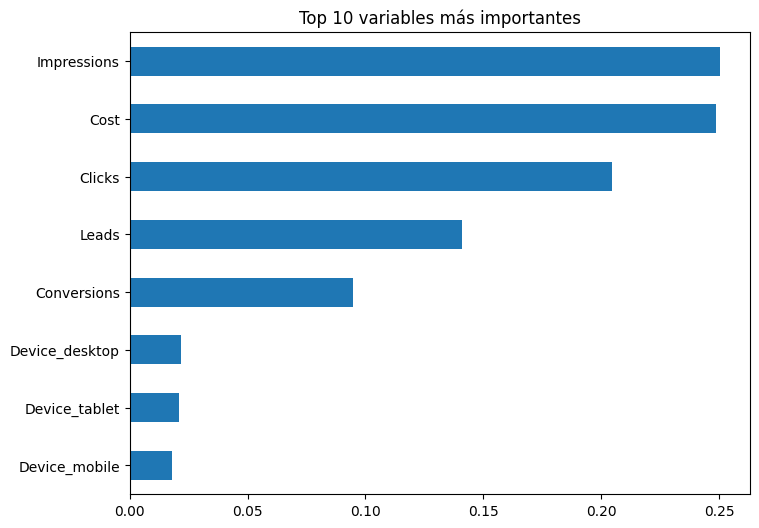

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd

# Features: numéricas y categóricas
num_cols = ["Cost", "Clicks", "Impressions", "Leads", "Conversions"]
cat_cols = ["Device"]

# Separar X e y (quitando filas sin target)
X = df[num_cols + cat_cols]
y = df["Sale_Amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocesamiento: imputar medianas en numéricas + OneHot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Modelo
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Pipeline
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", rf)])

pipe.fit(X_train, y_train)

# Importancia de variables
feature_names = num_cols + list(pipe.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(cat_cols))
importances = pd.Series(pipe.named_steps["model"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("//Importancia de variables (RandomForest)//")
print(importances)

# Gráfico
plt.figure(figsize=(8,6))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 variables más importantes")
plt.show()

## 4) Modelado y evaluación de modelos

### 4.a) Preparación de datos (X, y, train/test)

In [27]:
from sklearn.model_selection import train_test_split

# Variables más relevantes según RandomForest
features_finales = ["Impressions", "Cost", "Clicks", "Leads", "Conversions"]

X = df[features_finales]
y = df["Sale_Amount"]

# División en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (1660, 5)
Dimensiones X_test: (415, 5)


### 4.b) Definición de función de evaluación (métricas)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluar_modelo(nombre, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")
    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 4.c) Entrenar y evaluar los tres modelos

In [29]:
# Dummy Regressor (baseline)
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

res_dummy = evaluar_modelo("Dummy", y_test, y_pred_dummy)

=== Dummy ===
R²:   -0.0006
RMSE: 285.06
MAE:  240.46



In [30]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

res_lin = evaluar_modelo("Linear Regression", y_test, y_pred_lin)

=== Linear Regression ===
R²:   -0.0006
RMSE: 285.05
MAE:  240.98



In [31]:
# RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

res_rf = evaluar_modelo("Random Forest", y_test, y_pred_rf)

=== Random Forest ===
R²:   -0.0132
RMSE: 286.84
MAE:  241.62



### 4.d) Guardado y Comparación de resultados

In [32]:
# Guardamos todas las métricas en un DataFrame
resultados_mod = resultados = pd.DataFrame([res_dummy, res_lin, res_rf])
print(resultados)

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.000623  285.053986  240.981305
2      Random Forest -0.013170  286.835535  241.619133


### 4.e) Control con gráficos

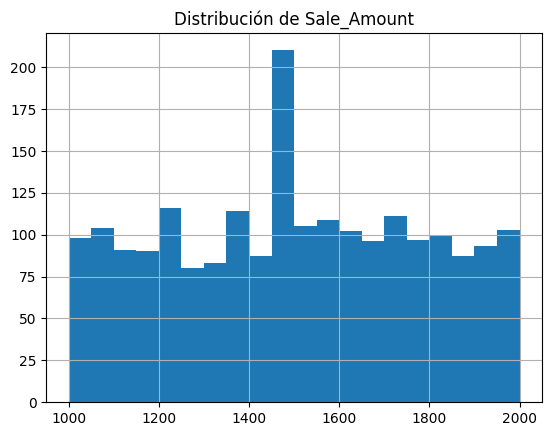

In [33]:
df["Sale_Amount"].hist(bins=20)
plt.title("Distribución de Sale_Amount")
plt.show()

El gráfico nos muestra que:

1. Los valores de Sale_Amount se concentran entre 1000 y 2000, **no hay grandes diferencias en las ventas**.

2. Hay solo un pico fuerte en los 1500.

3. Excepto por ese pico, la distribución es relativamente plana, sin grandes concentraciones en valores extremos.

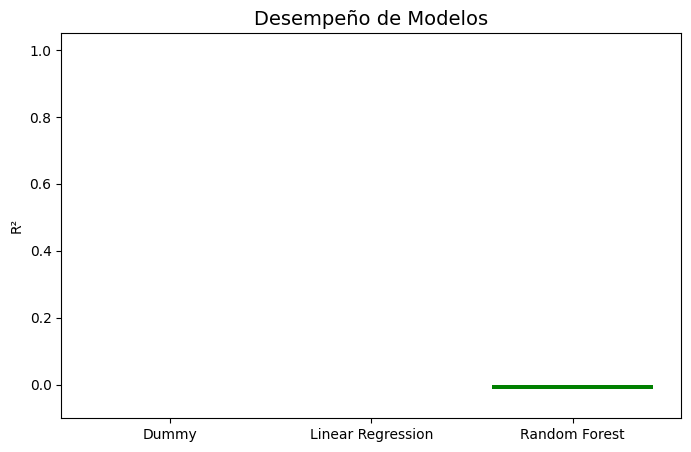

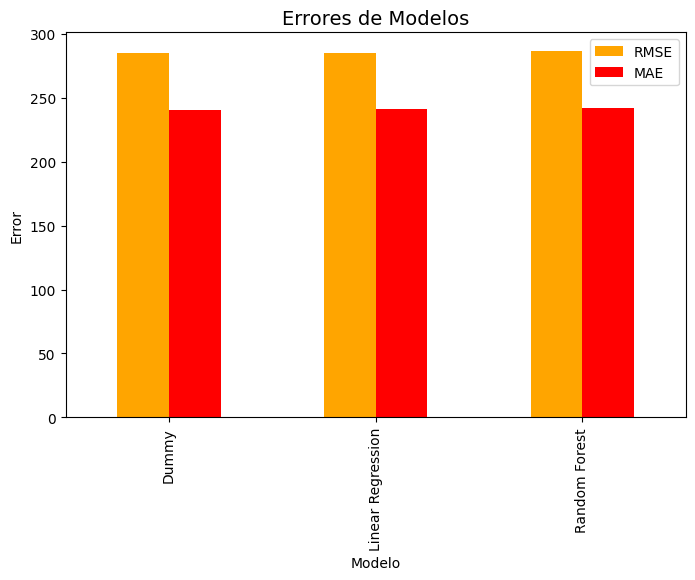

In [34]:
import matplotlib.pyplot as plt

# Resultados finales
resultados_mod_plot = resultados_mod.copy()

# Gráfico de barras para R²
plt.figure(figsize=(8,5))
plt.bar(resultados_mod_plot["Modelo"], resultados_mod_plot["R²"], color=["gray", "blue", "green"])
plt.title("Desempeño de Modelos", fontsize=14)
plt.ylabel("R²")
plt.ylim(-0.1, 1.05)
plt.show()

# Gráfico de barras para RMSE y MAE
resultados_mod_plot.set_index("Modelo")[["RMSE", "MAE"]].plot(
    kind="bar", figsize=(8,5), color=["orange", "red"])
plt.title("Errores de Modelos", fontsize=14)
plt.ylabel("Error")
plt.show()

**Análisis de resultados de los modelos respecto a el gráfico de Sale_Ammount**: los modelos no superan al Dummy.

👉 Nuestra media de Sale_Amount del set de entrenamiento, ronda en 1500.

👉 Resultados con variables seleccionadas:
- Dummy: R² = -0.0006, RMSE ≈ 285, MAE ≈ 240

- Linear Regression: R² = -0.0006, RMSE ≈ 285, MAE ≈ 241

- Random Forest: R² = -0.0131, RMSE ≈ 287, MAE ≈ 242

👉 R² cercano a 0 o negativo, todos los modelos rinden igual o peor que el Dummy.

👉 Errores (RMSE y MAE) altos y similares entre Dummy, Regresión y Random Forest.

👉 Con estas variables, los modelos no muestran la variabilidad de Sale_Amount con los features.

# Parte B: Cambio de Target

En esta segunda parte se reformula el objetivo del proyecto: **como no fue posible superar el baseline al predecir Sale_Amount, se decide cambiar el target** para continuar con el objeto práctico del proyecto **y predecir la tasa de conversión (Conversion Rate)**, una métrica clave en marketing digital. Se documentan hipótesis, preparación de datos, modelos entrenados, métricas y conclusiones.

## 5) Nuevas Hipótesis

- **H0**: Las variables disponibles no permiten superar al modelo Dummy en la predicción del Conversion Rate.
- **H1**: Al entrenar modelos con variables adecuadas, se logra superar al Dummy en la predicción del Conversion Rate

## 6) Creación de nuevas features

### 6.a) Selección y creación de features

In [14]:
# Primero veamos la métrica que nos falta: CTR Crear columna CTR (Click Through Rate = Clicks / Impressions)
df["CTR"] = df["Clicks"] / df["Impressions"]

# Reemplazar infinitos y NaN por 0 (en caso de impresiones = 0)
df["CTR"] = df["CTR"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Control rápido
print(df[["Clicks", "Impressions", "CTR"]].head())

   Clicks  Impressions       CTR
0     104         4498  0.023121
1     173         5107  0.033875
2      90         4544  0.019806
3     142         3185  0.044584
4     156         3361  0.046415


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Crear feature CTR
df["CTR"] = df["Clicks"] / df["Impressions"]
df["CTR"] = df["CTR"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Definimos las features predictoras y la variable objetivo
features_conv = ["Clicks", "Impressions", "CTR"]
X = df[features_conv]
y = df["Conversions"]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 3)
Dimensiones de y: (2075,)


### 6.b) Train / Test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1660, 3)
X_test: (415, 3)


### 6.c) Redefinición de función de evaluación (métricas)

In [18]:
def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 6.d) Entrenamiento y Evaluación de modelos

In [20]:
resultados = []

dummy = DummyRegressor(strategy="mean")
resultados.append(evaluar_modelo("Dummy", dummy, X_train, X_test, y_train, y_test))

linreg = LinearRegression()
resultados.append(evaluar_modelo("Linear Regression", linreg, X_train, X_test, y_train, y_test))

rf = RandomForestRegressor(n_estimators=200, random_state=42)
resultados.append(evaluar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test))

=== Dummy ===
R²:   -0.0078
RMSE: 2.20
MAE:  1.90

=== Linear Regression ===
R²:   -0.0119
RMSE: 2.21
MAE:  1.90

=== Random Forest ===
R²:   -0.2507
RMSE: 2.45
MAE:  2.06


=== Resultados comparativos ===
              Modelo        R²      RMSE       MAE
0              Dummy -0.007763  2.203298  1.899839
1  Linear Regression -0.011912  2.207829  1.899808
2      Random Forest -0.250667  2.454511  2.060702


### 6.e) Guardado y Comparación de resultados

In [22]:
df_resultados = pd.DataFrame(resultados)
print("\n=== Resultados comparativos ===")
print(df_resultados)


=== Resultados comparativos ===
              Modelo        R²      RMSE       MAE
0              Dummy -0.007763  2.203298  1.899839
1  Linear Regression -0.011912  2.207829  1.899808
2      Random Forest -0.250667  2.454511  2.060702


**Análisis:**  Ningún modelo supera al Dummy, lo que significa que Clicks, Impressions y CTR no tienen poder predictivo suficiente sobre Conversions en este dataset.

### 6.f) Control con gráficos: Visualización de predicciones vs reales (Random Forest)

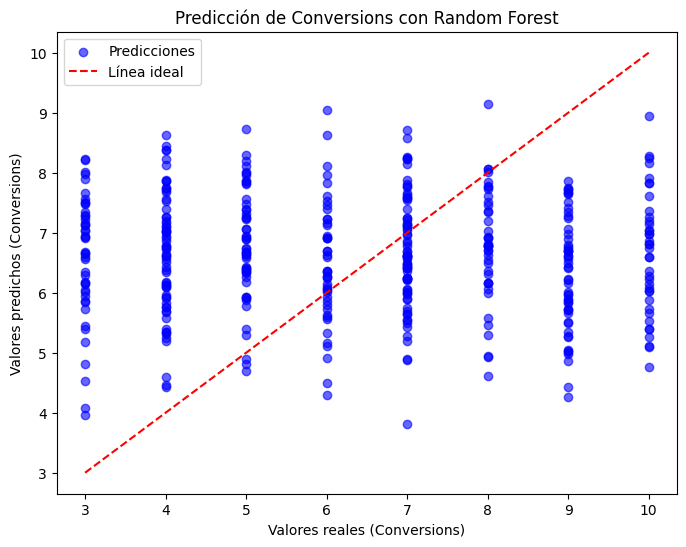

In [21]:
y_pred = rf.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Línea ideal")
plt.xlabel("Valores reales (Conversions)")
plt.ylabel("Valores predichos (Conversions)")
plt.title("Predicción de Conversions con Random Forest")
plt.legend()
plt.show()

**Análisis:** Los puntos están dispersos horizontalmente.

El modelo tiende a predecir valores “promedio” (alrededor de 5–7 conversions) sin capturar la variabilidad real.

Esto confirma lo que muestran las métricas: el modelo no logra aprender relaciones claras entre las features y la variable objetivo.

## 7) Validación de Hipótesis

- **Hipótesis nula (H0):**
Los modelos de Machine Learning (Regresión Lineal y Random Forest) no superan al modelo base (Dummy) en la predicción de Conversiones.


- **Hipótesis alternativa (H1)**:
Se rechaza la H1, ya que los modelos no lograron superar al baseline y no mostraron capacidad predictiva real en este dataset.

# Conclusión General


En este proyecto se intentó predecir Sale_Amount y Conversions en campañas de Google Ads con distintos modelos de Machine Learning. Ninguno logró superar al modelo base (Dummy), lo que indica que las variables disponibles no aportan suficiente información para predicciones confiables.

👉 Se presume que esta limitación se debe a que el dataset es ficticio y simplificado, lo que reduce la posibilidad de capturar relaciones reales. Aun así, el trabajo permitió practicar el flujo completo de un proyecto de Data Science, desde la limpieza de datos hasta la evaluación de modelos.

# Líneas Futuras

- **Probar con datasets reales** de campañas publicitarias para evaluar el desempeño de los modelos en contextos más representativos.

- **Incorporar más variables explicativas** (ej. calidad de anuncio, segmentación geográfica detallada, temporalidad de campañas).

- **Experimentar con otros algoritmos de regresión** (XGBoost, Gradient Boosting) y aplicar ajuste de hiperparámetros para mejorar resultados.

- **Enfocarse en la ingeniería de features**, buscando nuevas métricas derivadas relevantes para marketing digital.